The goal of this notebook is to have a completly self contained demo (training from scratch) for state of the art performance on CIFAR-10 to serve as a baseline. Sadly it is only at about 80% testing accuracy.

Here I ported the MXNet Inception V3 CNN to Lasagne and Theano. It shuffles batches and stops after a fixed number of iterations.

To run this demo you need to install theano and lasagne. As of right now the BatchNormLayer does not exist in the standard pip package so the development version is needed.

    pip install theano
    pip install lasagne
    pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip

This is based on a bunch of other code:
https://github.com/jseppanen/cifar_lasagne/blob/master/cifar_lasagne.ipynb
https://github.com/dmlc/mxnet/blob/master/example/image-classification/symbol_inception-bn-28-small.py

To convert this notebook into a python script run `jupyter nbconvert --to python lasagne-cifar10-inception-example.ipynb`


In [2]:
import theano, theano.tensor as T
import numpy as np, matplotlib.pyplot as plt
import os, time, random, sys
notebook_start_time = time.time()

import lasagne
from lasagne.layers.normalization import BatchNormLayer
from lasagne.layers import Conv2DLayer, InputLayer, ConcatLayer
from lasagne.layers import DenseLayer, Pool2DLayer, FlattenLayer

print "theano",theano.version.full_version
print "lasagne",lasagne.__version__

theano 0.8.2.dev-RELEASE
lasagne 0.2.dev1


In [3]:
#Set seed for random numbers:
np.random.seed(1234)
lasagne.random.set_rng(np.random.RandomState(1234))

In [4]:
##Uncomment these lines to fetch the dataset
!wget -c http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvf cifar-10-python.tar.gz

--2016-11-19 01:22:21--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [5]:
data_dir_cifar10 = os.path.join(".", "cifar-10-batches-py")

def one_hot(x, n):
    x = np.array(x)
    assert x.ndim == 1
    return np.eye(n)[x]

def _load_batch_cifar10(filename, dtype='float32'):
    path = os.path.join(data_dir_cifar10, filename)
    batch = np.load(path)
    data = batch['data'] / 255.0 # scale between [0, 1]
    labels = one_hot(batch['labels'], n=10) # convert labels to one-hot representation
    return data.astype(dtype), labels.astype(dtype)

def cifar10(dtype='float32', grayscale=True):
    x_train = []
    t_train = []
    for k in xrange(5):
        x, t = _load_batch_cifar10("data_batch_%d" % (k + 1), dtype=dtype)
        x_train.append(x)
        t_train.append(t)

    x_train = np.concatenate(x_train, axis=0)
    t_train = np.concatenate(t_train, axis=0)

    x_test, t_test = _load_batch_cifar10("test_batch", dtype=dtype)

    if grayscale:
        x_train = _grayscale(x_train)
        x_test = _grayscale(x_test)

    return x_train, t_train, x_test, t_test

# load data
x_train, t_train, x_test, t_test = cifar10(dtype=theano.config.floatX,grayscale=False)
labels_test = np.argmax(t_test, axis=1)

print "x_train.shape:",x_train.shape

# reshape data
x_train = x_train.reshape((x_train.shape[0], 3, 32, 32))
x_test = x_test.reshape((x_test.shape[0], 3, 32, 32))


x_train.shape: (50000, 3072)


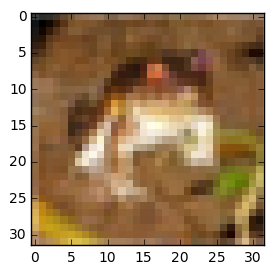

In [6]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 3)

a  = np.rollaxis(np.rollaxis(x_train[0],2,0),2,0)
plt.imshow(a,interpolation='none')

In [7]:
input_var = T.tensor4('inputs')

input_shape = (None, 3, 32, 32)
network = InputLayer(shape=input_shape, input_var=input_var)

# from MXNet 
def ConvFactory(data, num_filter, filter_size, stride=(1,1), pad=(0, 0)):
    data = BatchNormLayer(Conv2DLayer(
        data, num_filters=num_filter,
        filter_size=filter_size,
        stride=stride, pad=pad,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform(gain='relu')))
    return data

def DownsampleFactory(data, ch_3x3):
    conv = ConvFactory(data=data, filter_size=(3, 3), stride=(2, 2), num_filter=ch_3x3, pad=(1, 1))
    pool = Pool2DLayer(data, pool_size=3, stride=(2, 2), pad=(1, 1), mode='max')
    concat = ConcatLayer([conv, pool])
    return concat

def SimpleFactory(data, ch_1x1, ch_3x3):
    conv1x1 = ConvFactory(data=data, filter_size=(1, 1), pad=(0, 0), num_filter=ch_1x1)
    conv3x3 = ConvFactory(data=data, filter_size=(3, 3), pad=(1, 1), num_filter=ch_3x3) 
    concat = ConcatLayer([conv1x1, conv3x3])
    return concat
        
def get_symbol(network, num_classes = 10):
    conv1 = ConvFactory(data=network, filter_size=(3,3), pad=(1,1), num_filter=96)
    in3a = SimpleFactory(conv1, 32, 32)
    in3b = SimpleFactory(in3a, 32, 48)
    in3c = DownsampleFactory(in3b, 80)
    in4a = SimpleFactory(in3c, 112, 48)
    in4b = SimpleFactory(in4a, 96, 64)
    in4c = SimpleFactory(in4b, 80, 80)
    in4d = SimpleFactory(in4c, 48, 96)
    in4e = DownsampleFactory(in4d, 96)
    in5a = SimpleFactory(in4e, 176, 160)
    in5b = SimpleFactory(in5a, 176, 160)
    pool = Pool2DLayer(in5b, pool_size=7, stride=1, pad=1, mode='average_exc_pad')
    
    flatten = FlattenLayer(pool)
    dense = DenseLayer(flatten, num_units=num_classes, nonlinearity=lasagne.nonlinearities.rectify)
    out = DenseLayer(dense, num_units=num_classes, nonlinearity=lasagne.nonlinearities.softmax)
    
    return out

network = get_symbol(network)

In [8]:
output_shape = lasagne.layers.get_output_shape(network)
print "input_shape:",input_shape,"-> output_shape:",output_shape
sys.stdout.flush()

input_shape: (None, 3, 32, 32) -> output_shape: (None, 10)


In [9]:
#Output functions
output = lasagne.layers.get_output(network)
y = T.argmax(output, axis=1)
f_predict = theano.function([input_var], y)
print "DONE building output functions"

DONE building output functions


In [10]:
#Training function
target_var = T.matrix('target')
loss = lasagne.objectives.squared_error(output, target_var)
loss = loss.mean()

lr = theano.shared(np.array(0, dtype=theano.config.floatX))
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=lr)
#updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=lr, momentum=0.9)

f_train = theano.function([input_var, target_var], loss, updates=updates)
print "DONE building training functions"

DONE building training functions


In [11]:
# train model
lr.set_value(0.001)
batch_size = 2**9
print "batch_size:",batch_size

stats = []
for i in range(0,20):
    start_time = time.time()
    trainerror = []
    
    #Decrease learning rate!
    if (i % 5) == 0:
        lr.set_value((lr.get_value()*0.9).astype(theano.config.floatX))
        print "lr reduced:", lr.get_value()
    
    #Shuffle batches!
    order = range(0,len(x_train))
    random.shuffle(order)
    x_train = x_train[order]
    t_train = t_train[order]
    
    #Start batch training!
    for start in range(0, len(x_train), batch_size):
        x_batch = x_train[start:start + batch_size]
        t_batch = t_train[start:start + batch_size]
        cost = f_train(x_batch, t_batch)
        trainerror.append(cost)
        #print "batch error: %.5f" % cost
    elapsed_time = time.time() - start_time
    
    ## Calculate test error (just for logging)
    pred = np.array([])
    for start in range(0, len(x_test), batch_size):
        pred = np.append(pred,f_predict(x_test[start:start + batch_size]))
    testacc = np.mean(pred == labels_test)
    
    epocherror = np.mean(trainerror)
    stats.append((testacc,epocherror))
    
    print "iteration: %d, trainerror: %.5f, accuracy: %.5f, seconds: %d" % (i, epocherror,testacc, elapsed_time)


batch_size: 512
lr reduced: 0.000900000042748
iteration: 0, trainerror: 0.06596, accuracy: 0.60590, seconds: 129
iteration: 1, trainerror: 0.04510, accuracy: 0.70870, seconds: 131
iteration: 2, trainerror: 0.03566, accuracy: 0.75910, seconds: 131
iteration: 3, trainerror: 0.02800, accuracy: 0.77980, seconds: 131
iteration: 4, trainerror: 0.02283, accuracy: 0.80120, seconds: 131
lr reduced: 0.000810000055935
iteration: 5, trainerror: 0.01832, accuracy: 0.81340, seconds: 131
iteration: 6, trainerror: 0.01457, accuracy: 0.81830, seconds: 131
iteration: 7, trainerror: 0.01209, accuracy: 0.82250, seconds: 131
iteration: 8, trainerror: 0.01075, accuracy: 0.82860, seconds: 131
iteration: 9, trainerror: 0.00894, accuracy: 0.82930, seconds: 131
lr reduced: 0.000729000079446
iteration: 10, trainerror: 0.00689, accuracy: 0.83980, seconds: 131
iteration: 11, trainerror: 0.00527, accuracy: 0.83270, seconds: 131
iteration: 12, trainerror: 0.00439, accuracy: 0.83600, seconds: 132
iteration: 13, train

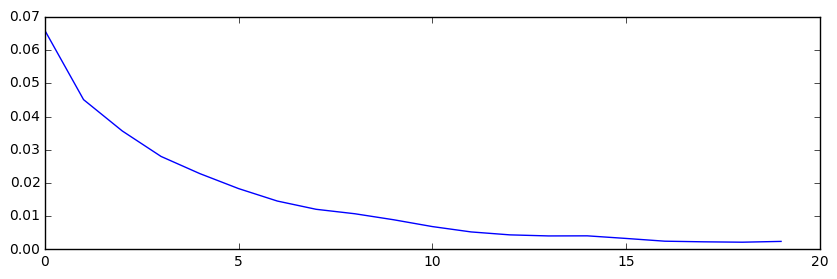

In [12]:
statsnp = np.rollaxis(np.asarray(stats),0,2)
plt.plot(statsnp[1])

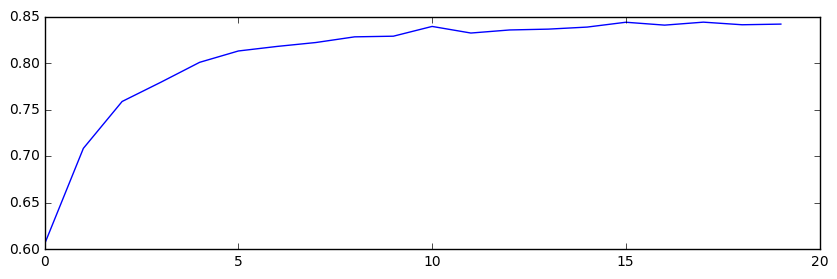

In [13]:
plt.plot(statsnp[0])

In [14]:
"Max Testing Accuracy", max(statsnp[0])

('Max Testing Accuracy', 0.84440000000000004)

In [15]:
notebook_elapsed_time = time.time() - notebook_start_time
print "Notebook took", notebook_elapsed_time/60.0, "minutes"

Notebook took 48.0419564486 minutes
